### Math 104C Final Project
#### Danming Wang, 5833587

In [111]:
import math
import numpy as np
import matplotlib
from matplotlib import pyplot
import scipy.sparse.linalg # to use tridiagonal solver

##### 1. The cellar
##### a)
$\textit{Proof:}$ The backward (implicit Euler) difference scheme for (1) is $$\frac{T_j^{n+1}-T_j^n}{k}=\kappa\frac{T_{j+1}^{n+1}-2T_{j}^{n+1}+T_{j-1}^{n+1}}{h^2},$$ which can be rewritten as $$T_j^n=T_j^{n+1}-\alpha(T_{j+1}^{n+1}-2T_{j}^{n+1}+T_{j-1}^{n+1})=-\alpha T_{j+1}^{n+1}+(1+2\alpha )T_{j}^{n+1}-\alpha T_{j-1}^{n+1}$$ where $\alpha=\kappa\frac{k}{h^2}$.      
To prove that the backward difference scheme for (1) is consistent, we find that  
$\begin{align*}
        \tau(h,k)&=\frac{T(x,t+k)-T(x,t)}{k}-\kappa\frac{T(x+h,t+k)-2T(x,t+k)+T(x-h,t+k)}{h^2}\\
        &=\left(T_t+O(k)\right)-\kappa\ \frac{h^2T_{xx}+O(h^4)}{h^2} \\
        &=T_t+O(k)-\kappa T_{xx}+O(h^2)\\
        &=O(k)+O(h^2) \text{ since $T_t=\kappa T_{xx}$}
\end{align*}$  
As $k, h\to 0$, $\tau(x,k)\to 0$. So the scheme is consistent and is second order accurate in space and first order accurate in time.  
To find the stability condition for the scheme, we do the Von Neumann Analysis.  
Substituting $T_j^n=g^n e^{imjh}$ into the scheme and cancelling out $g^n e^{imjh}$, we get  
$\begin{align*}
        1&=g-\alpha g(e^{imh}-2+e^{-imh})\\
        &=g+2\alpha g(1-\cos(mh)),\text{ since $\cos(\theta)=\frac{e^{i\theta}+e^{-i\theta}}{2}$}\\
        &=[1+2\alpha(1-\cos(mh))]g\\
        \Rightarrow\ g&=\frac{1}{1+2\alpha(1-\cos(mh))}
\end{align*}$  
Then the amplification factor is $g(m)=\frac{1}{1+2\alpha(1-\cos(mh))}$. Since $-1\leq \cos(mh)\leq 1$, we get $0\leq 1-\cos(mh) \leq 2$ $\Rightarrow$ $2\alpha(1-\cos(mh))\geq 0$. So $1+2\alpha(1-\cos(mh))\geq 1$. Then $g(m)=\frac{1}{1+2\alpha(1-\cos(mh))}\leq 1$ for all $m\in \mathbb{Z}$. Then $|g(m)|\leq 1$ for all $\alpha=\sigma\frac{k}{h^2}$. Therefore, the backward (implicit Euler) difference scheme is unconditionally stable.  

##### b)

In [112]:
def BFD(I, f,L, T, sigma,h,k):
    # I: initial conditions u_0(x)
    # f: u(0,t)
    # L: endpoint
    # T: maximum time
    # h: Delta x
    # k: Delta t
    M= int((L-0)/h) # M: number of x's
    N= int((T-0)/k) # N: number of t's
    x=np.linspace(0,L,M+1) # mesh points in space
    t=np.linspace(0,T,N+1) # mesh points in time 
    a = sigma*k/(h**2) # a: alpha
    u = np.zeros(M+1) # unknown u at new time level
    u_n = np.zeros(M+1) # u at the previous time level
    u_all=[] # u at all time levels
    
    # Representation of sparse matrix and right-hand side 
    #  (Using the fact that A is a tridiagonal matrix)
    main = np.zeros(M+1)
    lower = np.zeros(M)
    upper = np.zeros(M)
    b = np.zeros(M+1)
    # Precompute sparse matrix
    main[:]=1+2*a
    lower[:]=-a
    upper[:]=-a
    # Insert boundary conditions
    main[0]=1
    main[M]=1
    upper[0]=0
    lower[M-1]=0
    
    A = scipy.sparse.diags(diagonals=[main,lower,upper],
                          offsets = [0,-1,1], shape=(M+1,M+1), format='csr')
    # print(A.todense()) to check A
    
    # Set initial condition u_0(x)=I(x)
    for j in range(0,M+1):
        u_n[j]=I(k,x[j])
    u_all.append(u_n.copy())
    
    for n in range(0,N):
        b=u_n
        b[0]=f(t[n]) # boundary conditions
        b[-1]=0.0 
        u[:]= scipy.sparse.linalg.spsolve(A,b) 
        u_all.append(u.copy())
        u_n[:]=u
    
    return u_n,x,t,u_all

In [113]:
def f(t):
    #T(0,t)
    # 1/2 year summer, 1/2 year winter
    if math.sin(2*t/(3.15*10**7)*math.pi)>=0:
        return 15
    else:
        return -15
q1=0.71
def u0(k,x):
    return f(k)*pow(math.e,-q1*x)
    

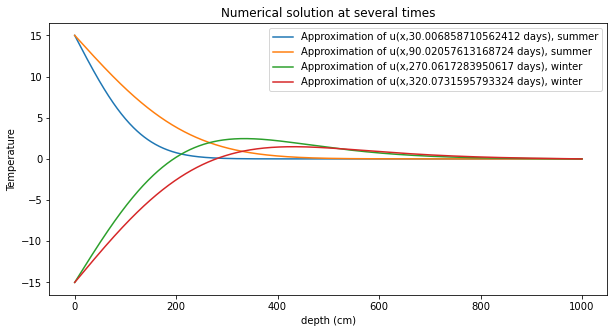

In [114]:
kappa=2*pow(10,-3) #thermometric diffusivity, cm^2/sec
L=1000 # cm
T=3.15*10**7*2 # sec, 2 years
h=1
k=86400/2
day=86400 # 1 day
x=BFD(u0, f,L, T, kappa,h,k)[1]
u_all=BFD(u0, f,L, T, kappa,h,k)[3]
t=BFD(u0,f, L, T, kappa,h,k)[2]
pyplot.figure( figsize=( 10, 5 ) )
pyplot.plot(x, u_all[30*2], label = 'Approximation of u(x,{0} days), summer'.format(t[30*2]/day))
pyplot.plot(x, u_all[90*2], label = 'Approximation of u(x,{0} days), summer'.format(t[90*2]/day))

pyplot.plot(x, u_all[270*2], label = 'Approximation of u(x,{0} days), winter'.format(t[270*2]/day))
pyplot.plot(x, u_all[320*2], label = 'Approximation of u(x,{0} days), winter'.format(t[320*2]/day))
pyplot.title("Numerical solution at several times")
pyplot.xlabel('depth (cm)')
pyplot.ylabel('Temperature')
pyplot.legend()

##### c)

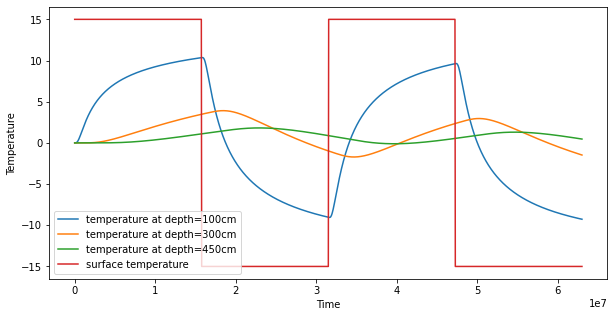

In [115]:
u450=[] # 2-year temperature at depth 450 cm
u1=[]
u3=[]
for i in range(len(t)):
    u1.append(u_all[i][100])
    u3.append(u_all[i][300])
    u450.append(u_all[i][450])
fi=[] # 2-year temperature at surface
for i in range(len(t)):
    fi.append(f(t[i]))

pyplot.figure( figsize=( 10, 5 ) )
pyplot.plot(t,u1,label='temperature at depth=100cm')
pyplot.plot(t,u3,label='temperature at depth=300cm')
pyplot.plot(t,u450,label='temperature at depth=450cm')
pyplot.plot(t,fi,label='surface temperature')
pyplot.xlabel('Time')
pyplot.ylabel('Temperature')
pyplot.legend(loc="lower left")

From the above graph and the graph in part b), we can see that at depth$=450cm=4.5m$, the temperature is opposite in phase to the surface temperature.

##### 2. A simple model for air quality control
##### a)
$\textit{Solution:}$ To find the stability condition for the scheme (4), we use the Von Neumann Analysis.  
    Let $k=\Delta t,h=\Delta x,\lambda=U_w\frac{k}{h}$ and $\alpha=D\frac{k}{h^2}$. Since $U_w<0$ and $D>0$, it follows that $\lambda<0$ and $\alpha>0$.  
    Rewrite the scheme (4) as $$ u_m^{n+1}=u_m^n-\lambda(u_{m+1}^n-u_m^n)+\alpha(u_{m+1}^{n+1}-2u_{m}^{n+1}+u_{m-1}^{n+1}).$$
    Substituting $u_j^n=g^n e^{imjh}$ into the scheme and cancelling out $g^n e^{imjh}$, we get  
    $\begin{align*}
        g&=1-\lambda(e^{imh}-1)+\alpha g(e^{imh}-2+e^{-imh})\\
        &=1-\lambda(\cos(mh)+i\sin(mh)-1)+2\alpha g(\cos(mh)-1)\\
        \Rightarrow\ g&=\frac{1+\lambda(1-\cos(mh)-i\sin(mh))}{1+2\alpha(1-\cos(mh))}\\
        \Rightarrow\ |g|^2&=\frac{[1+\lambda(1-\cos(mh)]^2+\lambda^2\sin^2(mh)}{[1+2\alpha(1-\cos(mh))]^2}\\
        &=\frac{1+2\lambda(1-\cos(mh))+\lambda^2(1-\cos(mh))^2+\lambda^2(1-\cos^2(mh))}{[1+2\alpha(1-\cos(mh))]^2}\\
        &=\frac{1+2\lambda(1-\cos(mh))+2\lambda^2(1-\cos(mh))}{1+4\alpha(1-\cos(mh))+4\alpha^2(1-\cos(mh))^2}
    \end{align*}$  
To make the scheme stable, we need $|g|\leq 1$, i.e. $|g|^2\leq 1$. So we need  
    $\begin{align*}
        &\frac{1+2\lambda(1-\cos(mh))+2\lambda^2(1-\cos(mh))}{1+4\alpha(1-\cos(mh))+4\alpha^2(1-\cos(mh))^2}\leq 1\\
        \Rightarrow\ &1+2\lambda(1-\cos(mh))+2\lambda^2(1-\cos(mh))\leq 1+4\alpha(1-\cos(mh))+4\alpha^2(1-\cos(mh))^2\\
        \Rightarrow\ & \lambda+\lambda^2\leq 2\alpha+2\alpha^2(1-\cos(mh))\\
        \Rightarrow\ & \frac{\lambda}{\alpha^2}+\frac{\lambda^2}{\alpha^2}\leq \frac{2}{\alpha}+2(1-\cos(mh))
    \end{align*}$  
And since $0<1-\cos(mh)<2$, we just need $\frac{\lambda}{\alpha^2}+\frac{\lambda^2}{\alpha^2}\leq \frac{2}{\alpha}$. Let $\mu=\frac{\lambda}{\alpha}$, then $\mu<0$ since $\lambda<0$ and the inequality becomes $\frac{\mu}{\alpha}+\mu^2\leq \frac{2}{\alpha}$, $\alpha\mu^2+\mu-2\leq 0$. $\frac{-1-\sqrt{1+8\alpha}}{2\alpha}\leq\mu\leq \frac{-1+\sqrt{1+8\alpha}}{2\alpha}$. Since $\mu<0$, we need $\frac{-1-\sqrt{1+8\alpha}}{2\alpha}<0$, i.e. $\sqrt{1+8\alpha}>-1$, which is always true regardless of the choice of $\alpha=D\frac{k}{h^2}$.  
So the scheme is unconditionally stable.

##### b)
The "upwind" scheme for $u_t+U_wu_x=0$ is $\frac{u_j^{n+1}-u_j^n}{\Delta t}+U_w\frac{u_{j+1}^n-u_j^n}{\Delta x}=0$. Let $k=\Delta t$ and $h=\Delta x$ and $\lambda=-U_w\frac{k}{h}$. Since $U_w<0$, $\lambda>0$.  
Substituting $u_j^n=g^n e^{imjh}$ into the "upwind" scheme and cancelling out $g^n e^{imjh}$, we get  
$\begin{align*}
&\frac{g-1}{k}+U_w\frac{e^{imh}-1}{h}=0\\
\Rightarrow\ & g=1+\lambda(\cos(mh)+i\sin(mh)-1), \text{ since $e^{i\theta}=\cos(\theta)+i\sin(\theta)$}\\
\Rightarrow\ & |g|^2=[1+\lambda(\cos(mh)-1)]^2+\lambda^2\sin^2(mh)\\
&\quad=1+2\lambda(\cos(mh)-1)+2\lambda^2-2\lambda^2\cos(mh), \text{ since $\cos^2\theta+\sin^2\theta=1$ for all $\theta$}
\end{align*}$  
To make the "upwind" scheme stable, we need $|g|\leq 1$, i.e. $|g|^2\leq 1$. Then  
$\begin{align*}
&1+2\lambda(\cos(mh)-1)+2\lambda^2-2\lambda^2\cos(mh)\leq 1\\
\Rightarrow\ & (\cos(mh)-1)+\lambda-\lambda\cos(mh)\leq 0\\
\Rightarrow\ & (\lambda-1)(1-\cos(mh))\leq 0
\end{align*}$  
And since $0<1-\cos(mh)<2$, we just need $\lambda-1\leq 0$, i.e. $\lambda\leq 1$, to make the "upwind" scheme stable. This is equivalent to $-U_w\frac{k}{h}\leq 1$ $\Rightarrow\ \frac{k}{h}\leq \frac{1}{-U_w}$.  
Since $u_t+U_wu_x=0$, then $u_t=-U_wu_x$ and $u_{tt}=-U_wu_{xt}=-U_wu_{tx}=-U_wu_{xx}$. It follows that  
$\begin{align*}
\frac{u(x,t+k)-u(x,t)}{k}&=u_t(x,t)+\frac{1}{2}ku_{tt}(x,t)+O(k^2), \text{ and}\\
U_w\frac{u(x+h,t)-u(x,t)}{h}&=U_w\left(u_x(x,t)+\frac{1}{2}hu_{xx}(x,t)+O(h^2)\right)
\end{align*}$  
Then  
$\begin{align*}
&\quad\frac{u(x,t+k)-u(x,t)}{k}+U_w\frac{u(x+h,t)-u(x,t)}{h}\\
&=u_t+U_wu_x+U_w\frac{1}{2}hu_{xx}+\frac{1}{2}ku_{tt}+O(k^2)+O(h^2)\\
&=u_t+U_wu_x+\frac{1}{2}h\left(U_wu_{xx}+\lambda u_{xx}\right)+O(k^2)+O(h^2)\\
&=u_t+U_wu_x+\frac{1}{2}h(U_w+\lambda)u_{xx}+O(k^2)+O(h^2)\\
&=O(k^2)+O(h^2),
\end{align*}$  
since $\lambda\leq 1$ for stability $\Rightarrow\ \sigma=-\frac{1}{2}h(U_w+\lambda)\geq 0$ as $U_w<0$, and hence $u_t+U_wu_x=-\frac{1}{2}U_wh(1-\lambda)u_{xx}$. Therefore, the "upwind" scheme satisfies an equation of the form $u_t+U_wu_x=\sigma u_xx$ with $\sigma\geq 0$ to second order accuracy.  

To guarantee that our numerical diffusion is much less than the "real" diffusion when $D\neq 0$, we need to ensure that our scheme (4) satisfies monotonicity. Again let $k=\Delta t,h=\Delta x,\lambda=U_w\frac{k}{h}, \alpha=D\frac{k}{h^2}$. We can rewrite the scheme (4) as  
$\begin{align*}
&u_j^{n+1}=u_j^n-\lambda(u_{j+1}^n-u_j^n)+\alpha(u_{j+1}^{n+1}-2u_j^{n+1}+u_{j-1}^{n+1})\\
\Rightarrow\ & -\alpha u_{j+1}^{n+1}+(1+2\alpha)u_j^{n+1}-\alpha u_{j-1}^{n+1}=-\lambda u_{j+1}^n+(1+\lambda)u_j^n
\end{align*}$  
If $1+\lambda\geq 0$, i.e. $\lambda\geq -1$, then $|-\alpha u_{j+1}^{n+1}+(1+2\alpha)u_j^{n+1}-\alpha u_{j-1}^{n+1}|\leq -\lambda |u_{j+1}^n|+(1+\lambda)|u_j^n|$. Taking the max over $j$ and recall that $\|u\|_\infty=\max_j|u_j|$, we get $\|u^{n+1}\|_\infty \leq \|u^n\|_\infty$ for all $n$.  
So we need $\lambda=U_w\frac{k}{h}\geq -1$, i.e. $h\geq -U_w k$ to guarantee that our numerical diffusion is much less than the "real" diffusion when $D\neq 0$.

##### c)
Let $k=\Delta t,h=\Delta x,\lambda=U_w\frac{k}{h}, \alpha=D\frac{k}{h^2}$, We can rewrite the scheme as  
$\begin{align*}
&u_j^{n+1}=u_j^n-\lambda(u_{j+1}^n-u_j^n)+\alpha(u_{j+1}^{n+1}-2u_j^{n+1}+u_{j-1}^{n+1})\\
\Rightarrow\ & -\alpha u_{j+1}^{n+1}+(1+2\alpha)u_j^{n+1}-\alpha u_{j-1}^{n+1}=-\lambda u_{j+1}^n+(1+\lambda)u_j^n
\end{align*}$


In [116]:
def scheme(I, T, a,b, Uw, D,h,k):
    # I: initial conditions u_0(x,y)
    # a,b: space interval [a,b]
    # Bc: Boundary condition
    # T: maximum time
    # h: Delta x 
    # k: Delta t
    M= int((b-a)/h) # M: number of x's
    N= int((T-0)/k) # N: number of t's
    x=np.linspace(a,b,M+1) # mesh points in space
    t=np.linspace(0,T,N+1) # mesh points in time 
    alpha = D*k/(h**2) 
    lamb = Uw*k/h
    u = np.zeros(M+1) # unknown u at new time level
    u_n = np.zeros(M+1) # u at the previous time level
    u_all=[] # u at all time levels
    
    # Representation of sparse matrix and right-hand side 
    #  (Using the fact that A is a tridiagonal matrix)
    main = np.zeros(M+1)
    lower = np.zeros(M)
    upper = np.zeros(M)
    b = np.zeros(M+1)
    # Precompute sparse matrix
    main[:]=1+2*alpha
    lower[:]=-alpha
    upper[:]=-alpha
    # Insert boundary conditions
    main[0]=1
    main[M]=1
    upper[0]=0
    lower[M-1]=0
   
    A = scipy.sparse.diags(diagonals=[main,lower,upper],
                          offsets = [0,-1,1], shape=(M+1,M+1), format='csr')
    
    # Representation of matrix B
    #  (Using the fact that B is a tridiagonal matrix)
    main = np.zeros(M+1)
    lower = np.zeros(M)
    upper = np.zeros(M)
    b = np.zeros(M+1)
    # Precompute sparse matrix
    main[:]=1+lamb
    upper[:]=-lamb
    # Insert boundary conditions
    main[0]=1
    main[M]=1
    upper[0]=0
    lower[M-1]=0
    
    B = scipy.sparse.diags(diagonals=[main,lower,upper],
                          offsets = [0,-1,1], shape=(M+1,M+1), format='csr')
    #print(B.todense())
    
    # Set initial condition u(x,0)=u_0(x)=I(x)
    for j in range(0,M+1):
        u_n[j]=I(x[j])
    u_all.append(u_n.copy())
    for n in range(0,N):
        b=B@u_n
        b[0]=0.0 # plug in the homogeneous Dirichlet boundary condition u=0
        b[-1]=0.0 
        u[:]= scipy.sparse.linalg.spsolve(A,b) 
        u_n[:]=u        
        u_all.append(u.copy())
    return u,u_all,x,t
#u holds latest solution, i.e. u(T,x), u holds solution at all time levels

Choose $\Delta x=\Delta t=0.1$.

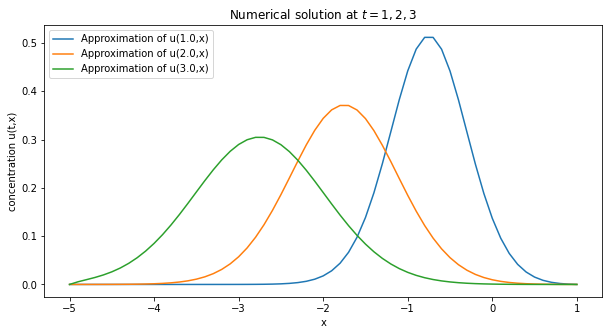

In [117]:
def u0(x): #u0(x)
    if 0<=x<=1/2:
        return 1
    else:
        return 0
T=5
a=-5
b=1    
Uw=-1
D=0.1
h=0.1
k=0.1
u_all=scheme(u0, T, a,b, Uw, D,h,k)[1]
x=scheme(u0, T, a,b, Uw, D,h,k)[2]
t=scheme(u0, T, a,b, Uw, D,h,k)[3]
pyplot.figure( figsize=( 10, 5 ) )
pyplot.plot(x, u_all[10], label = 'Approximation of u({0},x)'.format(t[10]))
pyplot.plot(x, u_all[20], label = 'Approximation of u({0},x)'.format(t[20]))
pyplot.plot(x, u_all[30], label = 'Approximation of u({0},x)'.format(t[30]))
pyplot.xlabel('x')
pyplot.ylabel('concentration u(t,x)')
pyplot.title('Numerical solution at $t=1,2,3$')
pyplot.legend()